In [1]:

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [107]:
import torch
import pandas as pd
from src.tools.preprocess import preprocess_data
import matplotlib.pyplot as plt
import rasterio
from skimage import exposure
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import  cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
data = pd.read_csv('../data/processed/data.csv')
data_clean = preprocess_data(data[data["dataset"]=="train"])
data_clean.head()

tif_path     8
ndvi        17
evi          8
ndwi        17
gndvi       17
savi         8
msavi        8
dtype: int64


,Unnamed: 0,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,...,ndwi,gndvi,savi,msavi,SDate_year,SDate_month,SDate_day,HDate_year,HDate_month,HDate_day
0,0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25,2024-04-14,97,...,8.488031,0.127153,0.151125,4232.596191,2023,11,25,2024,4,14
1,1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13,2024-04-26,82,...,11.493762,0.187815,0.282110,3249.392822,2023,11,13,2024,4,26
2,2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19,2024-04-28,92,...,10.166884,0.206553,0.309869,3741.956055,2023,12,19,2024,4,28
3,3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11,2024-11-04,91,...,10.446196,0.220995,0.309350,3673.396729,2023,2,11,2024,11,4
4,4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12,2024-05-19,94,...,8.665929,0.160657,0.269563,4227.338379,2023,12,12,2024,5,19


In [47]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image


def scale_band(band):
    """Scale band data to 0-255."""
    band_min = np.min(band)
    band_max = np.max(band)
    return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


class TiffDataset(Dataset):
    def __init__(self, directory, data, type="train", transform=None, gamma=0.6, contrast_stretch=True):
        self.directory = directory
        self.transform = transform
        self.gamma = gamma
        self.contrast_stretch = contrast_stretch
        self.images = data.loc[(data["tif_path"].str.endswith('.tif')) & (data["dataset"] == type),
                               "tif_path"
                               ].tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.images[idx])

        # Open the image file
        with rasterio.open(img_path) as src:
            # Read RGB bands (assuming Sentinel-2 band order: Red=B4, Green=B3, Blue=B2)
            red = src.read(3)
            green = src.read(2)
            blue = src.read(1)

            # Scale each band to the 0–255 range for better visualization
            red_scaled = scale_band(red)
            green_scaled = scale_band(green)
            blue_scaled = scale_band(blue)

            # Stack the scaled RGB bands into a single image
            rgb = np.dstack((red_scaled, green_scaled,
                            blue_scaled)).astype(np.uint8)

            # Apply contrast stretching if specified
            if self.contrast_stretch:
                p2, p98 = np.percentile(rgb, (2, 98))
                rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98))

            # Apply gamma correction to adjust brightness
            rgb = exposure.adjust_gamma(rgb, gamma=self.gamma)

            # Convert NumPy array to PIL Image
            rgb = Image.fromarray(rgb)

            if self.transform:
                rgb = self.transform(rgb)

        return rgb

In [48]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(degrees=30),  
    transforms.RandomAffine(translate=(0.1, 0.1), degrees=20),  
    transforms.ToTensor()
])

In [77]:

train_dataset = TiffDataset(directory="../data", data=data_clean, type="train", transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TiffDataset(directory="../data", data=data_clean, type="test", transform=transform)
test_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [78]:
import torch


import torch

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 3, stride=2, padding=1),  # 32x32 -> 16x16
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Dropout(0.2),

            torch.nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 16x16 -> 8x8
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(0.2),

            torch.nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 8x8 -> 4x4
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.Flatten(),

            torch.nn.Linear(256 * 4 * 4, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(64, 5)  # Code latent réduit à 4
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(5, 64), 
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(64, 256 * 4 * 4),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256 * 4 * 4),

            torch.nn.Unflatten(1, (256, 4, 4)),
            torch.nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),

            torch.nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),   # 8x8 -> 16x16
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),

            torch.nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),    # 16x16 -> 32x32
            torch.nn.Sigmoid() 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [79]:
autoencoder = Autoencoder().to(device)

In [81]:
def train_dataset(autoencoder, train_loader, num_epochs=10, learning_rate=1e-4):
    autoencoder = Autoencoder().to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
    train_loss = []
    test_loss = []

    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, data in enumerate(train_loader):
            autoencoder.train()
            # Normaliser les données entre 0 et 1
            data = data.to(device)
            optimizer.zero_grad()
            output = autoencoder(data)
            output = output.float()
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        else:
            autoencoder.eval()
            total_loss_test = 0
            for batch_idx, data in enumerate(test_dataloader):
                with torch.no_grad():
                    data = data.to(device)
                    output = autoencoder(data)
                    output = output.float()
                    loss = criterion(output, data)
                    total_loss_test += loss.item()
        avg_loss_test = total_loss_test / len(test_dataloader)
        avg_loss = total_loss / len(train_loader)
        train_loss.append(avg_loss)
        test_loss.append(avg_loss_test)
        print(f'Epoch {epoch}: Average Loss = {avg_loss:.4f}',
              f'Average Loss Test = {avg_loss_test:.4f}')

    return autoencoder, train_loss, test_loss

In [82]:
autoencoder, train_loss, test_loss = train_dataset(autoencoder, train_dataloader)

Epoch 0: Average Loss = 0.0910 Average Loss Test = 0.0578
Epoch 1: Average Loss = 0.0579 Average Loss Test = 0.0488
Epoch 2: Average Loss = 0.0518 Average Loss Test = 0.0455
Epoch 3: Average Loss = 0.0492 Average Loss Test = 0.0444
Epoch 4: Average Loss = 0.0479 Average Loss Test = 0.0432
Epoch 5: Average Loss = 0.0470 Average Loss Test = 0.0427
Epoch 6: Average Loss = 0.0465 Average Loss Test = 0.0424
Epoch 7: Average Loss = 0.0458 Average Loss Test = 0.0422
Epoch 8: Average Loss = 0.0454 Average Loss Test = 0.0417
Epoch 9: Average Loss = 0.0453 Average Loss Test = 0.0414


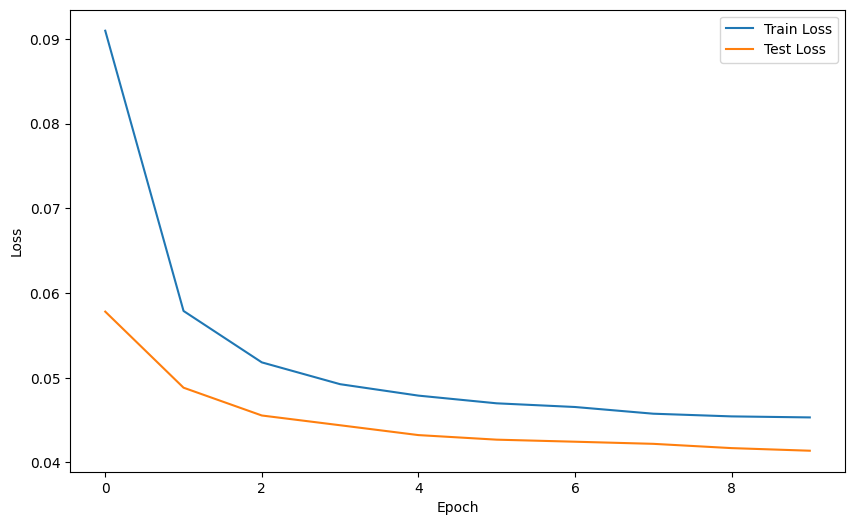

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [55]:
for batch_idx, data in enumerate(test_dataloader):
    with torch.no_grad():
        data = data.to(device)[0]
        output = autoencoder.encoder(data.unsqueeze(0))
        print(output)
        break

tensor([[15.9482, -9.7721,  5.6004,  2.6929]], device='cuda:0')


In [86]:
feature_columns = [
    'CropCoveredArea', 'CHeight', 'IrriCount', 'WaterCov', 'ExpYield',
    'ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi', 'SDate_year', 'SDate_month',
       'SDate_day', 'HDate_year', 'HDate_month', 'HDate_day'
]
X = data_clean[feature_columns]
y = data_clean['category']

In [102]:
X = []
y = []
for index, row in data_clean.iterrows():
    img_path = os.path.join("../data", row["tif_path"])
    x = list(row[feature_columns])
    y.append(row['category'])
    with rasterio.open(img_path) as src:
        red = src.read(3)
        green = src.read(2)
        blue = src.read(1)
        red_scaled = scale_band(red)
        green_scaled = scale_band(green)
        blue_scaled = scale_band(blue)
        rgb = np.dstack((red_scaled, green_scaled,
                        blue_scaled)).astype(np.uint8)
        p2, p98 = np.percentile(rgb, (2, 98))
        rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98))
        rgb = exposure.adjust_gamma(rgb, gamma=0.6)
        rgb = Image.fromarray(rgb)
        rgb = transform(rgb).unsqueeze(0).to(device)
        output = autoencoder.encoder(rgb)
        output = output.cpu().detach().numpy().squeeze()
        output = [float(x) for x in output]
        x.extend(output)
        X.append(x)

In [108]:
X = np.array(X)
y = np.array(y)
le = LabelEncoder()
y = le.fit_transform(y)

In [109]:
X.shape, y.shape

((6874, 22), (6874,))

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [112]:
load_model = False
if load_model:
    best_lenear_model = joblib.load('best_svm_model_with_encoder_decoder.joblib')
else:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear', "sigmoid","poly"],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
    svm = SVC(random_state=42)
    grid_search = GridSearchCV(
        svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_lenear_model = grid_search.best_estimator_
    cv_scores = cross_val_score(
        best_lenear_model, X_train, y_train, cv=5, scoring='f1_macro'
    )
    cv_scores

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [113]:
y_pred =  best_lenear_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.07      0.06      0.06        81
           1       0.82      0.90      0.86      1134
           2       0.10      0.04      0.06        95
           3       0.00      0.00      0.00        65

    accuracy                           0.75      1375
   macro avg       0.25      0.25      0.25      1375
weighted avg       0.69      0.75      0.72      1375



In [114]:
#save model
joblib.dump(best_lenear_model, 'best_svm_model_with_encoder_decoder.joblib')

['best_svm_model_with_encoder_decoder.joblib']